In [1]:
#Import packages
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as intgr
from numpy import sqrt
import numpy.linalg as lin
%matplotlib inline

In [2]:
def trunc_pdf(xvals, mu, sigma, cutoff='None', cdf=0):
    '''
    This function takes a vector of data and model parameters and returns the truncated p.d.f. 
        (or c.d.f.) of each observation in the model.
    
    Args: 
            xvals: the vector of observations
            mu: the expectation of the normal distribution.
            sigma: the standard deviation of the normal distribution.
            cutoff: the cutoff point of the model. Probability above the cutoff point will be set to zero.
            cdf: 0 means returning a vector of p.d.f., while 1 means returning a vector of c.d.f..
    
    Returns:
            vals: a vector of p.d.f. or c.d.f. of the vector of observations in the model.
    '''
    if cdf:
        if cutoff == 'None':
            vals = sts.lognorm.cdf(xvals, s=sigma, scale=np.exp(mu))
        else:
            prob_notcut = sts.lognorm.cdf(cutoff, s=sigma, scale=np.exp(mu)) - sts.lognorm.cdf(0, s=sigma, scale=np.exp(mu))
            vals = sts.lognorm.cdf(xvals, s=sigma, scale=np.exp(mu)) / prob_notcut
    else:
        if cutoff == 'None':
            vals = sts.lognorm.pdf(xvals, s=sigma, scale=np.exp(mu))
        else:
            prob_notcut = sts.lognorm.cdf(cutoff, s=sigma, scale=np.exp(mu)) - sts.lognorm.cdf(0, s=sigma, scale=np.exp(mu))
            vals = sts.lognorm.pdf(xvals, s=sigma, scale=np.exp(mu)) / prob_notcut
    return vals

In [3]:
def moments_model(mu, sigma, cutoff):
    '''
    Return the two moments of our model: 
    
    Args:
        mu: the expectation of our model (normal)
        sigma: the standard deviation of our model (normal)
    
    Returns:
        mean: the expectation of the distribution specified by our parameters.
        sigma: the standard deviation of the distribution specified by our parameters.
    
    Note:
        This function calls the function trunc_pdf
    '''
    xfx = lambda x: x * trunc_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_pdf(x, mu, sigma, cutoff)
    (sigma_model, s_m_err) = sqrt(intgr.quad(x2fx, 0, cutoff))
    return mean_model, sigma_model

In [4]:
def moments_data(xvals):
    '''
    Return the two moments of our data:
    
    Args:
        xvals: the vector of data.
    
    Returns:
        mean: the mean of our data.
        std: the standard deviation of our data.
    
    Note:
        This function calls the function trunc_pdf
    '''
    return xvals.mean(), xvals.std()

In [5]:
def err_1(xvals, mu, sigma, cutoff):
    '''
    This is the error generating function:
    
    Args:
        xvals: the vector of data.
        mu: the expectation of our model assumed. (normal)
        sigma: the standard deviation of our model assumed. (normal)
        cutoff: the cutoff point. See function trunc_pdf for more explanation.
        
    Returns:
        err = (moments_model - moments_data) / moments_data
    
    Notes:
        This function calls two functions: moments_model and moments_data
    '''
    mean_model, sigma_model = moments_model(mu, sigma, cutoff)
    mean_data, sigma_data = moments_data(xvals)
    model = np.array([[mean_model], [sigma_model]])
    data = np.array([[mean_data], [sigma_data]])
    err = (model - data) / data
    
    return err

In [6]:
def crit_1(params, *args):
    '''
    This function returns the criterion function of our data:
    
    Args:
        params: a np.array consisting of the mu and sigma of the model assumed. (See the function moments_model for more explanation)
        args: a tuple consisting vector(s) of observations, the cutpoint, and the weighting matrix
        
    Returns:    
        critical_value = err.transpose @ Weighting_matrix @ err
    
    Note:
        This function calls the function err_1
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err_v = err_1(xvals, mu, sigma, cutoff)
    crit_val = err_v.T @ W @ err_v
    
    return crit_val

In [7]:
def permoments_data(xvals):
    '''
    This function returns a tuple of three moments of our data:
    
    Args:
        xvals: the vector of data
    
    Returns:
        per1: percentage of observations below $75,000 per year in the data
        per2: percentage of observations between $75,000 and $100,000 per year in the data
        per3: percentage of observations above $100,000 per year in the data
    '''
    per1 = len(xvals[xvals < 75000]) / len(xvals)
    per3 = len(xvals[xvals > 100000]) / len(xvals)
    per2 = 1 - per1 - per3
    return per1, per2, per3

In [8]:
def permoments_model(mu, sigma, cutoff):
    '''
    This function returns a tuple of three moments of the model assumed:
    
    Args:
        mu: the expectation of the model assumed.
        sigma: the standard deviation of the model assumed.
    
    Returns:
        per1: percentage of observations below $75,000 per year in the model
        per2: percentage of observations between $75,000 and $100,000 per year in the model
        per3: percentage of observations above $100,000 per year in the model
        
    Note: This function calls the function trunc_pdf
    '''
    per1 = trunc_pdf(75000, mu, sigma, cutoff, cdf=1)
    per2 = trunc_pdf(100000, mu, sigma, cutoff, cdf=1) - per1
    per3 = 1 - per2 - per1
    return per1, per2, per3

In [9]:
def err_2(xvals, mu, sigma, cutoff):
    '''
    This is the error generating function:
    
    Args:
        xvals: the vector of data.
        mu: the expectation of our model assumed. (normal)
        sigma: the standard deviation of our model assumed. (normal)
        cutoff: the cutoff point. See function trunc_pdf for more explanation.
        
    Returns:
        err = (moments_model - moments_data) / moments_data
    
    Notes:
        This function calls two functions: permoments_model and permoments_data
    '''
    per1_model, per2_model, per3_model = permoments_model(mu, sigma, cutoff)
    per1_data, per2_data, per3_data = permoments_data(xvals)
    model = np.array([[per1_model], [per2_model], [per3_model]])
    data = np.array([[per1_data], [per2_data], [per3_data]])
    err = (model - data) / data
    
    return err

In [10]:
def crit_2(params, *args):
    '''
    This function returns the criterion function of our data:
    
    Args:
        params: a np.array consisting of the mu and sigma of the model assumed. (See the function permoments_model for more explanation)
        args: a tuple consisting vector(s) of observations, the cutpoint, and the weighting matrix
        
    Returns:    
        critical_value = err.transpose @ Weighting_matrix @ err
    
    Note:
        This function calls the function err_2
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err_v = err_2(xvals, mu, sigma, cutoff)
    crit_val = err_v.T @ W @ err_v
    
    return crit_val

In [11]:
def rr(*args):
    '''
    The rounding function that is designed to deal with iterables.
    '''
    return list(np.round(x,4) for x in args)

## Problem 1

In [12]:
# Load Data
income = np.loadtxt('incomes.txt')

##### (a) Plot a histogram of percentages of the income.txt data with 30 bins. 
Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title

(0, 150000)

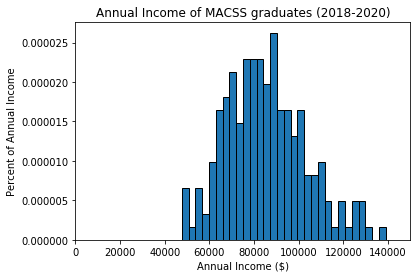

In [13]:
fig1 = plt.figure()

count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)

plt.title('Annual Income of MACSS graduates (2018-2020)')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Percent of Annual Income')
plt.xlim([0, 150000])

##### (b) Estimate the parameters of the lognormal distribution by generalized method of moments. 
Use the average income and standard deviation of income as
your two moments. Use the identity matrix as your weighting matrix W^ .
Plot your estimated lognormal PDF against the histogram from part (a).
Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two
model moments at the estimated parameter values.

In [14]:
mu_1, sigma_1 = 11.3, 0.21
params_1 = np.array([mu_1, sigma_1])
W_hat_1 = np.eye(2)
args_1 = (income, 150000, W_hat_1)
results_1A = opt.minimize(crit_1, params_1, args=(args_1),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

In [15]:
mu_GMM1, sig_GMM1 = results_1A.x
print('mu_GMM =', *rr(mu_GMM1), ' sig_GMM =', *rr(sig_GMM1))
print('Value of GMM criterion:', *crit_1(results_1A.x, *args_1)[0])

print('\naverage income(data) =', *rr(moments_data(income)[0]), '\nstandard deviation of income(data) =', *rr(moments_data(income)[1]))
model = moments_model(mu_GMM1, sig_GMM1, 150000)
print('\naverage income(model) =', *rr(model[0]), '\nstandard deviation of income(model) =', *rr(model[1]))

mu_GMM = 11.3336  sig_GMM = 0.2133
Value of GMM criterion: 6.7922655537e-14

average income(data) = 85276.8236 
standard deviation of income(data) = 17992.5421

average income(model) = 85276.8458 
standard deviation of income(model) = 17992.5425


#### The two moments (of the model and data) are kind of close.

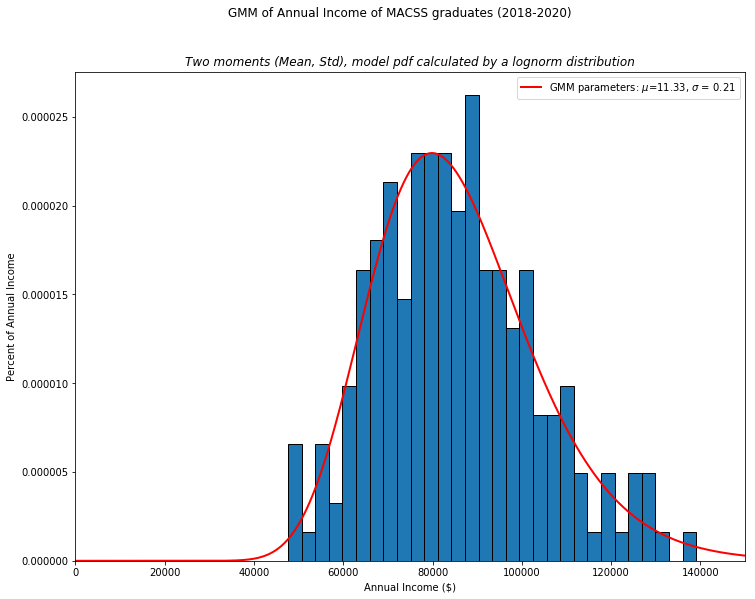

In [16]:
fig2 = plt.figure(figsize=(12,9))

count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)

plt.suptitle('GMM of Annual Income of MACSS graduates (2018-2020)')
plt.title('Two moments (Mean, Std), model pdf calculated by a lognorm distribution', style = 'italic')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Percent of Annual Income')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff = 150000),
     linewidth=2, color='r', label=f'GMM parameters: $\mu$={round(mu_GMM1,2)}, $\sigma$ = {round(sig_GMM1,2)}')
plt.legend(loc='best')

##### (c) Perform the two-step GMM estimator by using your estimates 
from part (b) with two moments to generate an estimator for the variance covariance
matrix Ω^2step, which you then use to get the two-step estimator for the
optimal weighting matrix W^ 2step. Report your estimates as well as the
criterion function value at these estimates. Plot your estimated lognormal
PDF against the histogram from part (a) and the estimated PDF from
part (b). Report and compare your two data moments against your two
model moments at the estimated parameter values.

In [17]:
err1 = err_1(income, mu_GMM1, sig_GMM1, cutoff=150000)
Omega_1 = err1 @ err1.T / income.shape[0]
W_hat_1B = lin.pinv(Omega_1) # Omega_1 is a sigular matrix

args_1B = (income, 150000, W_hat_1B)
results_1B = opt.minimize(crit_1, results_1A.x, args=(args_1B),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_1B.x

In [18]:
print('mu_GMM =', *rr(mu_GMM2), ' sig_GMM =', *rr(sig_GMM2))
print('Value of GMM criterion:', *crit_1(results_1B.x, *args_1B)[0])

print('\naverage income(data) =', *rr(moments_data(income)[0]), '\nstandard deviation(data) =', *rr(moments_data(income)[1]))
model1 = moments_model(mu_GMM1, sig_GMM1, 150000)
model2 = moments_model(mu_GMM2, sig_GMM2, 150000)
print('\naverage income(model: one-step) =', *rr(model1[0]), '\nstandard deviation(model: one-step) =', *rr(model1[1]))
print('\naverage income(model: two-step) =', *rr(model2[0]), '\nstandard deviation(model: two-step) =', *rr(model2[1]))

mu_GMM = 11.3336  sig_GMM = 0.2133
Value of GMM criterion: 0.00662255594787

average income(data) = 85276.8236 
standard deviation(data) = 17992.5421

average income(model: one-step) = 85276.8458 
standard deviation(model: one-step) = 17992.5425

average income(model: two-step) = 85276.8167 
standard deviation(model: two-step) = 17992.5634


#### The two moments (of the model and data) are kind of close.

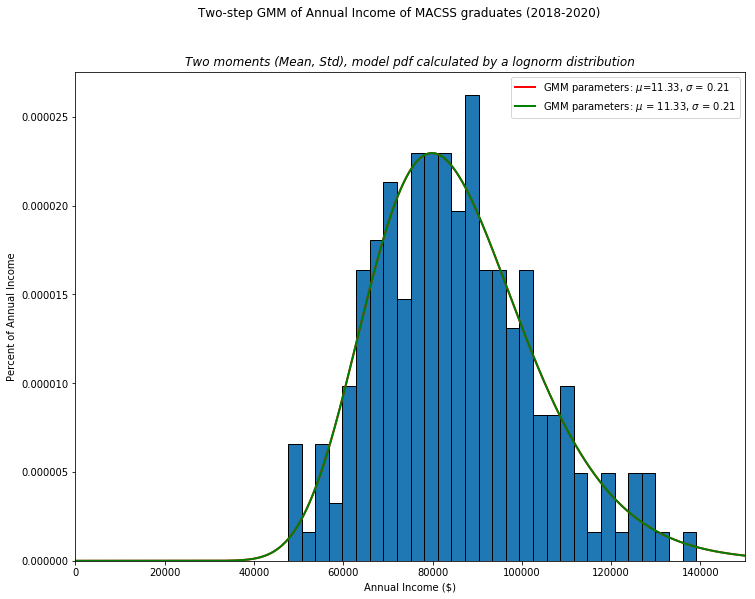

In [19]:
fig3 = plt.figure(figsize=(12,9))

count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)

plt.suptitle('Two-step GMM of Annual Income of MACSS graduates (2018-2020)')
plt.title('Two moments (Mean, Std), model pdf calculated by a lognorm distribution', style = 'italic')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Percent of Annual Income')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff = 150000),
     linewidth=2, color='r', label=f'GMM parameters: $\mu$={round(mu_GMM1,2)}, $\sigma$ = {round(sig_GMM1,2)}')
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM2, sig_GMM2, cutoff = 150000),
     linewidth=2, color='g', label=f'GMM parameters: $\mu$ = {round(mu_GMM2,2)}, $\sigma$ = {round(sig_GMM2,2)}')
plt.legend(loc='best')

##### (d) Now estimate the lognormal PDF to fit the data by GMM using different moments. 
Use percent of individuals who earn less than \$75,000, percent
of individuals who earn between \$75,000 and \$100,000, and percent of individuals who earn more than \$100,000 as your three moments. Use the
identity matrix as your estimator for the optimal weighting matrix. Plot (d) Now estimate the lognormal PDF to fit the data by GMM using different
moments. Use percent of individuals who earn less than \$75,000, percent
of individuals who earn between \$75,000 and \$100,000, and percent of individuals who earn more than \$100,000 as your three moments. Use the
identity matrix as your estimator for the optimal weighting matrix. Plot

In [20]:
mu_2, sigma_2 = 11.3, 0.212
params_2 = np.array([mu_2, sigma_2])
W_hat_2 = np.eye(3)
args_2 = (income, 'None', W_hat_2)
results_2 = opt.minimize(crit_2, params_2, args=(args_2),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

In [21]:
mu_GMM3, sig_GMM3 = results_2.x
print('mu_GMM =', *rr(mu_GMM3), ' sig_GMM =', *rr(sig_GMM3))
print('Value of GMM criterion:', (*crit_2(results_2.x, *args_2)[0]))
print('\nThree moments(data):', *rr(*permoments_data(income)))
model3 = permoments_model(mu_GMM3, sig_GMM3, 'None')
print('\nThree moments(model):', *rr(*model3))

mu_GMM = 11.3357  sig_GMM = 0.2106
Value of GMM criterion: 1.36717590596e-14

Three moments(data): 0.3 0.5 0.2

Three moments(model): 0.3 0.5 0.2


#### Data moments and model moments are very close

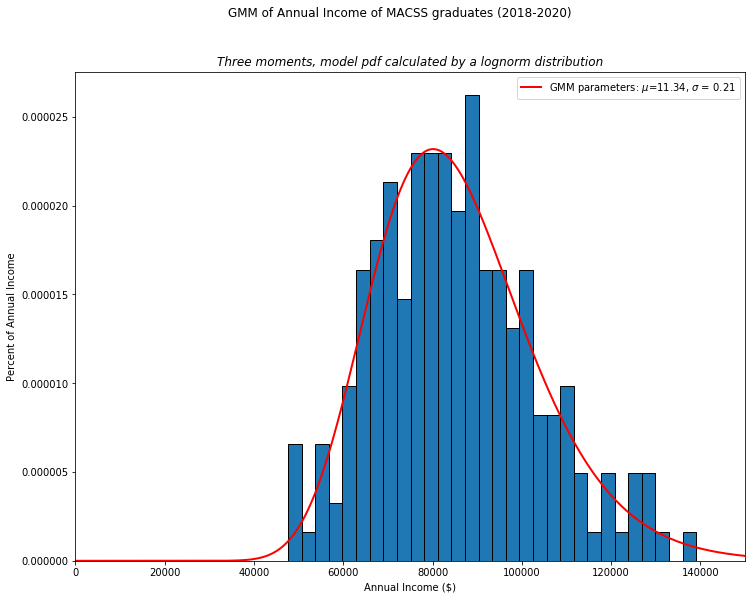

In [22]:
fig4 = plt.figure(figsize=(12,9))

count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)

plt.suptitle('GMM of Annual Income of MACSS graduates (2018-2020)')
plt.title('Three moments, model pdf calculated by a lognorm distribution', style = 'italic')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Percent of Annual Income')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM3, sig_GMM3, cutoff = 150000),
     linewidth=2, color='r', label=f'GMM parameters: $\mu$={round(mu_GMM3,2)}, $\sigma$ = {round(sig_GMM3,2)}')
plt.legend(loc='best')

##### (e) Perform the two-step GMM estimator by using your estimates from part (d) 
with three moments to generate an estimator for the variance covariance matrix Ω^2step, which you then use to get the two-step estimator for
the optimal weighting matrix W^ 2step. Report your estimates as well as
the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF
from part (d). Report and compare your three data moments against your
three model moments at the estimated parameter values.

In [23]:
err3 = err_2(income, mu_GMM3, sig_GMM3, cutoff=150000)
Omega_2 = err3 @ err3.T / income.shape[0]
W_hat_2B = lin.pinv(Omega_2) # Omega_2 is a sigular matrix

args_2B = (income, 150000, W_hat_2B)
results_2B = opt.minimize(crit_2, results_2.x, args=(args_2B),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results_2B.x

In [24]:
params_2B = np.array([mu_GMM4, sig_GMM4])

print('mu_GMM =', *rr(mu_GMM4), ' sig_GMM =', *rr(sig_GMM4))
print('Value of GMM criterion 4:', crit_2(params_2B, *args_2B)[0][0])
print('\nThe three moments(data):', *rr(permoments_data(income)))
print('\nThe three moments(model:one step):', *rr(permoments_model(mu_GMM3, sig_GMM3, 150000)))
print('\nThe three moments(model:two step):', *rr(permoments_model(mu_GMM4, sig_GMM4, 150000)))

mu_GMM = 11.3368  sig_GMM = 0.2114
Value of GMM criterion 4: 9.14285561065e-11

The three moments(data): [ 0.3  0.5  0.2]

The three moments(model:one step): [ 0.3009  0.5014  0.1977]

The three moments(model:two step): [ 0.2997  0.5003  0.2   ]


#### The moments are closer to the data moments in the second step.

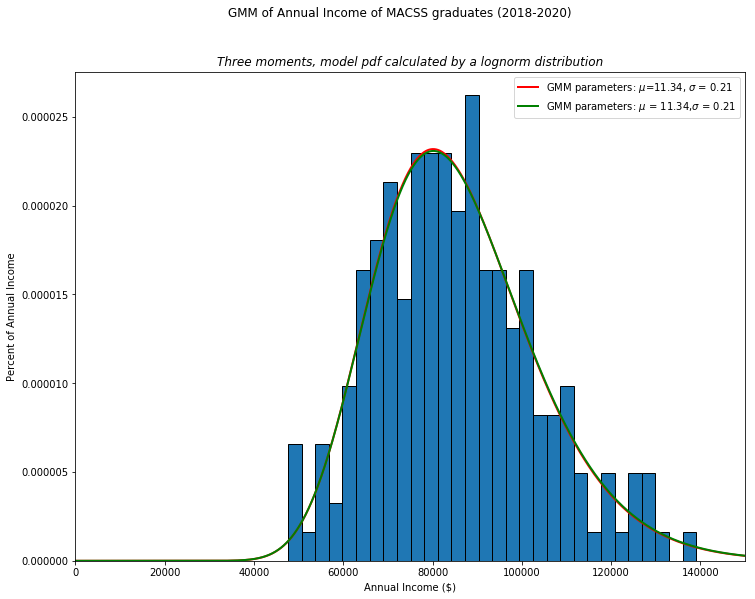

In [25]:
fig4 = plt.figure(figsize=(12,9))

count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)

plt.suptitle('GMM of Annual Income of MACSS graduates (2018-2020)')
plt.title('Three moments, model pdf calculated by a lognorm distribution', style = 'italic')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Percent of Annual Income')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM3, sig_GMM3, cutoff = 150000),
     linewidth=2, color='r', label=f'GMM parameters: $\mu$={round(mu_GMM3,2)}, $\sigma$ = {round(sig_GMM3,2)}')
plt.legend(loc='best')
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_GMM4, sig_GMM4, cutoff = 150000),
     linewidth=2, color='g', label=f'GMM parameters: $\mu$ = {round(mu_GMM4,2)},$\sigma$ = {round(sig_GMM4,2)}')
plt.legend(loc='best')

##### (f) Which of the four estimations from parts (b), (c), (d), and (e) fits the data best? Justify your answer.

Apparently the model in (d) yields the smallest criterion value, so model in (d) should fits the data best.

However, I noticed actually the weighting matrix is kind of important to our approximation so I would encourage a model that incorporates a matrix that try to balance all the effects of moments with different units of measurements.

## Problem 2

##### Estimate the parameters of the model (β0; β1; β2; β3) by GMM by solving the minimization problem of the GMM criterion function. 

In [26]:
#Load Data
sick = np.loadtxt('sick.txt', skiprows=1, delimiter=',')

In [27]:
def err_3(xvals, b0, b1, b2, b3):
    '''
    This is the error generating function:
    
    Args:
        xvals: the vector of data.
        b0, b1, b2, b3: the parameters of our model assumed. (linear)
    
    Internal objects:
        moms_data: the 'sick' vector
        moms_model: the 'sick' vector predicted by our model which is specified by our parameters (b0, b1, b2, b3)
        
    Returns:
        err = (moments_model - moments_data) 
    
    Notes:
        This function uses simple difference method to calculate the error term
    '''
    moms_data = sick[:,0]
    moms_model = b0 + b1*sick[:,1] + b2*sick[:,2] + b3*sick[:,3]
    err = moms_data - moms_model 
    return err

In [28]:
def crit_3(params, *args):
    '''
    This function returns the criterion function of our data:
    
    Args:
        params: a np.array consisting of the parameters of the model assumed. (See the function err_3 for more explanation)
        args: a tuple consisting vector(s) of observations and the weighting matrix
        
    Returns:    
        critical_value = err.transpose @ Weighting_matrix @ err
    
    Note:
        This function calls the function err_3
    '''
    b0, b1, b2, b3 = params
    xvals, W = args
    err = err_3(xvals, *params)
    crit_val = err.T @ W @ err
    return crit_val

In [29]:
params_3 = np.array([0, 0, 0, 0]) #Set all parameters to 0
W_hat_3 = np.eye(200)
args_3 = (sick, W_hat_3)

#estimate parameters
results_3 = opt.minimize(crit_3, params_3, args=(args_3), method = 'L-BFGS-B')
b0_GMM, b1_GMM, b2_GMM, b3_GMM = results_3.x

In [30]:
crit_sick = crit_3(results_3.x, *args_3)
print('b0_GMM=', round(b0_GMM,4), ' \nb1_GMM=', round(b1_GMM,4), '\nb2_GMM=', round(b2_GMM,4), ' \nb3_GMM=', round(b3_GMM,4))
print('Value of GMM criterion:', round(crit_sick,4))

b0_GMM= 0.2516  
b1_GMM= 0.0129 
b2_GMM= 0.4005  
b3_GMM= -0.01
Value of GMM criterion: 0.0018
